# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Data handling parameters

In [3]:
# Parameters
#
filename   = 'metadata/6-kanal-2.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [19]:
Lag        =   96
Horizon    =   6

# Data handling

## Import data


In [20]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.08 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-01-29 00:00:06,25.4,17.0,1.2,1.7,214.0,298.0
1,2022-01-29 00:00:21,25.4,17.0,1.2,2.0,213.0,299.0
2,2022-01-29 00:00:41,25.3,17.0,1.2,1.4,214.0,299.0


## Preprocess data

### Set index

In [21]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-01-29 00:00:00,1.227778
2022-01-29 00:05:00,1.833333
2022-01-29 00:10:00,1.626316


In [22]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [23]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Fixing Lag

In [24]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [25]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
        
    df_train = np.log( df_train )
    df_test  = np.log( df_test  )   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] Data transformation applied


In [26]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


### Stationarity

Augmented Dickey-Fuller test for unit root, $\alpha = 0.05$.

$H_0$: Time series have a unit root and it is non-stationary

$H_1$: Time series does not have a unit root and it is stationary

In [27]:
from statsmodels.tsa.stattools import adfuller

rows =[]

for feature in df.columns:
    
    row = [feature]
    dataset = df[feature]
    result = adfuller(dataset)
    row.extend([result[0],result[1]])
    #row.extend([value for key, value in result[4].items()])
    row.append('H0 Accepted' if result[1] > 0.05 else 'H0 Rejected')
    rows.append(row)
    
pd.DataFrame(rows,columns=['Dataset', 'ADF Statistic', 'p-value', 'Result'])

,Dataset,ADF Statistic,p-value,Result
0,PM2.5,-6.791395,2.359696e-09,H0 Rejected


### Homoskedasticity

Levene’s test checks for homogeneity of variances, $\alpha = 0.05$ 

$H_0$: The sub-samples variances of the time series are all equal.

$H_1$: At least one variance of the time series sub-samples is different.

In [28]:
from scipy.stats import levene

rows =[]

for feature in df.columns:
    
    row = [feature]
    dataset = df[feature]
    
    split = int(len(dataset)/2)
    ds1, ds2 = dataset[:split], dataset[split:]
    result = levene(ds1,ds2)
    row.extend([result.statistic,result.pvalue])
    #row.extend([value for key, value in result[4].items()])
    row.append('H0 Accepted' if result.pvalue > 0.05 else 'H0 Rejected')
    rows.append(row)
    
pd.DataFrame(rows,columns=['Dataset', 'Levene Statistic', 'p-value', 'Result'])

,Dataset,Levene Statistic,p-value,Result
0,PM2.5,161.520454,1.887484e-36,H0 Rejected


# Forecasting model

<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="http://bit.ly/pyFTSsite"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [29]:
from pyFTS.models.incremental import TimeVariant
from pyFTS.partitioners import Grid
from pyFTS.models import pwfts, hofts
from pyFTS.benchmarks import Measures


batch = 32

# for npart in [35, 70]:
#     for method in [hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
#         print('npart: {}, method: {}'.format(npart, method))
        
#         model = TimeVariant.Retrainer(partitioner_method = Grid.GridPartitioner, 
#                                       partitioner_params = {'npart': npart},
#                                       fts_method         = method,
#                                       fts_params         = {}, 
#                                       order              = 1,
#                                       batch_size         = batch, 
#                                       window_length      = Lag)

#         model.fit( df_train[ targetSeries ].to_numpy() )
# #         print('[INFO] TimeVariant model Trained')

#         rmse, mape, u = Measures.get_point_statistics( df_test[ targetSeries ].to_numpy(), model)
        
#         print('rmse, mape, u: ', rmse, mape, u)


model = TimeVariant.Retrainer(partitioner_method = Grid.GridPartitioner, 
                              partitioner_params = {'npart': 70},
                              fts_method         = hofts.WeightedHighOrderFTS,
                              fts_params         = {}, 
                              order              = 1,
                              batch_size         = batch, 
                              window_length      = Lag)

model.fit( df_train[ targetSeries ].to_numpy() )
print('[INFO] TimeVariant model Trained')

rmse, mape, u = Measures.get_point_statistics( df_test[ targetSeries ].to_numpy(), model)

print('rmse, mape, u: ', rmse, mape, u)

[INFO] TimeVariant model Trained
rmse, mape, u:  0.31 106.11 1.35


## Evaluation

### Get predictions

In [30]:
test = df_test[ targetSeries ].to_numpy()


pred  = []
testX = []
testY = []
for i in range(Lag, test.shape[0]-Lag-Horizon):
               
    pred  += [ model.forecast_ahead( test[:Lag+i], steps=6) ]
    testX += [ test[:Lag+i] ]
    testY += [ test[i+Lag:i+Lag+Horizon] ]

pred  = np.asarray( pred )
testX = np.asarray( testX )
testY = np.asarray( testY )

### Calculate Performance on Testing set - Prediction visualization


In [31]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
    print('Horizon: ', i)
    print('> MAE:   ', MAE)
    print('> RMSE:  ', RMSE)
    print('> SMAPE: ', SMAPE)
    print('> R2:    ', R2)
    print()

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  0
> MAE:    0.14896382513473963
> RMSE:   0.25036682135992816
> SMAPE:  15.996844412313193
> R2:     0.8904773813384319

Horizon:  1
> MAE:    0.2249496017747121
> RMSE:   0.3768922467600709
> SMAPE:  23.094506889354598
> R2:     0.7519525812164851

Horizon:  2
> MAE:    0.2791757785427734
> RMSE:   0.45527642801642715
> SMAPE:  28.264979516116867
> R2:     0.6382177692503375

Horizon:  3
> MAE:    0.3205482924247043
> RMSE:   0.5186400356768014
> SMAPE:  32.01662998698189
> R2:     0.5307560225609194

Horizon:  4
> MAE:    0.3521570429150737
> RMSE:   0.5677403613283323
> SMAPE:  34.89982956660781
> R2:     0.4379535399974178

Horizon:  5
> MAE:    0.3845385268907353
> RMSE:   0.6180036095346441
> SMAPE:  37.49380130106987
> R2:     0.33430756379866655



## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


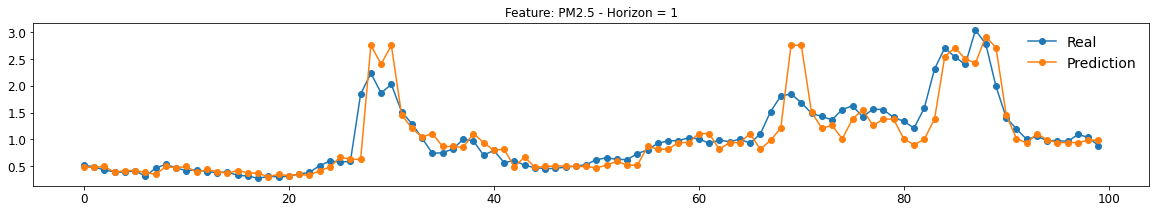

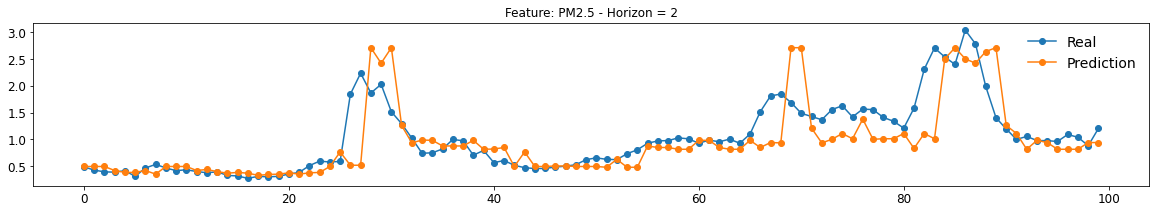

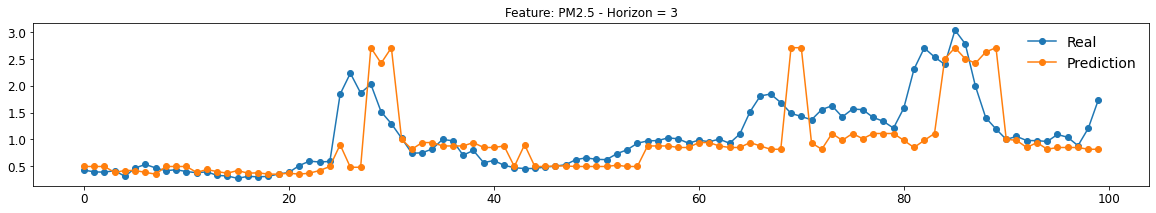

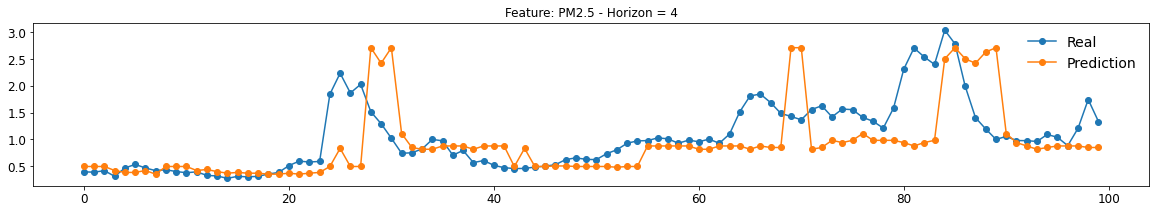

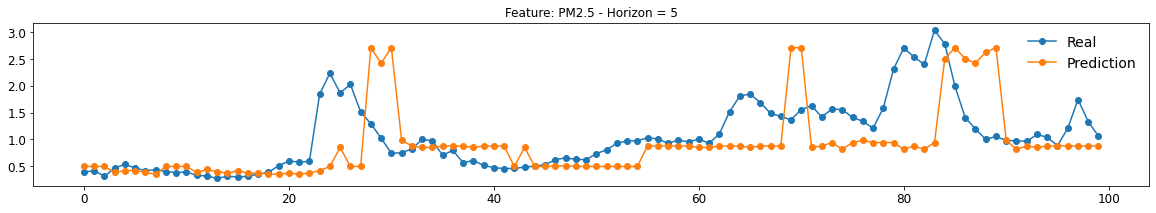

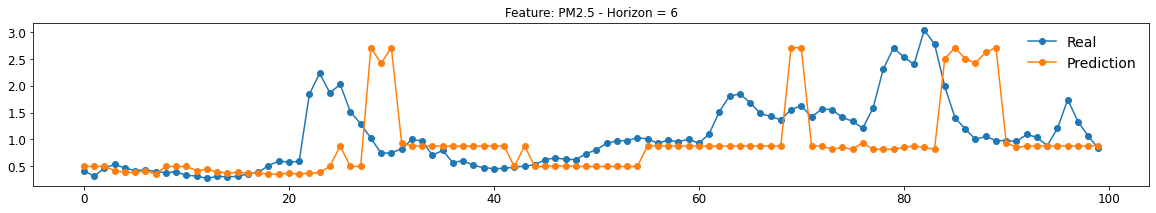

In [35]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )
    

    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

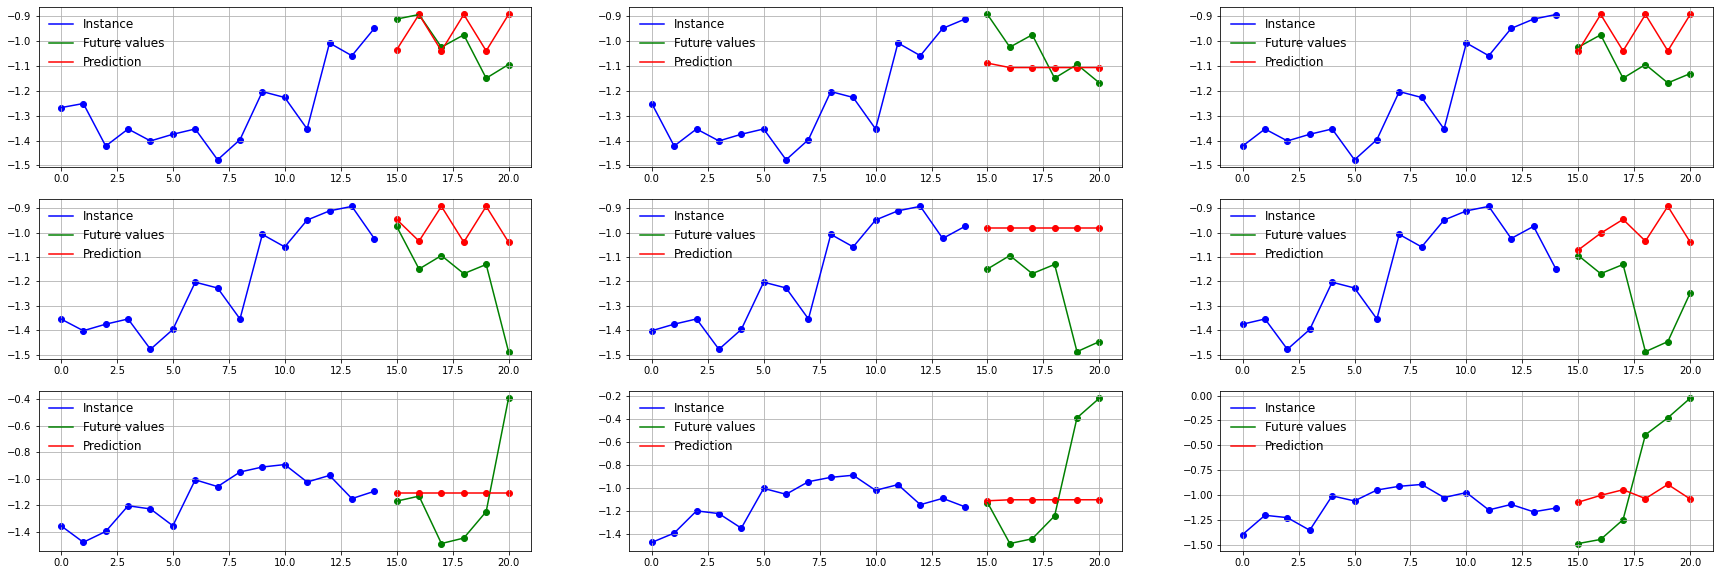

In [18]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (30, 10) )
# RandomInstances = [random.randint(1,testY.shape[0]) for i in range(0, 9)]
RandomInstances = [1,2,3,4,5,6,7,8,9]
for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, 15),             testX[i][-15:], color='b')
    plot_scatter(range(15, 15 + Horizon), testY[i], color='g')
    plot_scatter(range(15, 15 + Horizon), pred[i], color='r')

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()